In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.datasets import make_circles, make_classification,make_blobs, make_moons, make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from ipywidgets import interact, interactive, fixed, interact_manual


import math
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

## Model implementation

In [97]:
from sklearn.metrics import mean_squared_error

class MyGbmRegressor:
    def __init__(self, 
                 max_depth=3,
                 learning_rate=0.1,
                 n_estimators=100,
                 verbose=0,
                 random_state=None):
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.verbose = verbose
        self.random_state = random_state
        self.base_models = []
    
    def _get_estimator(self):
        # Will use tree as base estimator
        return DecisionTreeRegressor(max_depth=self.max_depth, splitter='best', criterion='squared_error', random_state=self.random_state)
    
    def get_loss(self, y_pred):
        return mean_squared_error(self.y, y_pred)
        
    def fit(self, X, y):
        def get_init_prediction(y):
            sample_count = len(y)

            F0 = np.zeros(sample_count)
            F0[:] = y.sum() / sample_count

            return F0        
        
        def calc_pseudo_residuals(y, y_pred):
            return (y - y_pred)
        
        self.X = X
        self.y = y
        
        sample_count = len(y)
        
        predictions = np.zeros((self.n_estimators+1, sample_count))
        residuals = np.zeros((self.n_estimators+1, sample_count))
        
        predictions[0] = get_init_prediction(y)
        residuals[0] = calc_pseudo_residuals(y, predictions[0])
        
        for m in range(1, self.n_estimators+1):
            last_pred = predictions[m-1]
            last_residuals = residuals[m-1]
            
            base_model = self._get_estimator()
            
            base_model.fit(X, last_residuals)
            res_pred = base_model.predict(X)
            
            predictions[m] = predictions[m-1] + self.learning_rate*res_pred
            residuals[m] = calc_pseudo_residuals(y, predictions[m])
            
            self.base_models.append(base_model)
            print(f"{m}:Loss: {self.get_loss(predictions[m]):.5f}, "+ \
                  f"diff loss: {self.get_loss(predictions[m])-self.get_loss(predictions[m-1]):.5f}, " + \
                  f"residuals: Mean {np.mean(residuals[m]):.5f}, Std {np.std(residuals[m]):.5f}")
        
        self.predictions = predictions
        self.residuals = residuals
        
        return self

    def _plot_step(self, step, axes):
            axes[0].scatter(self.X, self.y, c='b',s=10, label='y')
            axes[0].plot(self.X, self.predictions[step], c='r', label='pred')
            axes[0].legend()
            axes[0].set_title(f"Step {step}, Loss: {self.get_loss(self.predictions[step]):.5f}")
            
            axes[1].scatter(self.X, self.residuals[step], c='g',s=10, label='residuals')
            axes[1].axhline(y=0, c='c')
            axes[1].legend()
            
    def plot_steps(self):
        def get_optimal_axes():
            ncols = 2
            nrows = self.n_estimators+1
            
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey=True)

            fig.set_figheight(5*nrows)
            fig.set_figwidth(6*ncols)

            return axes
        
        axes = get_optimal_axes()
        
        for i in range(self.n_estimators+1):
            self._plot_step(i, axes[i])
            
            
    def plot_step_interactive(self):
        def plot_step(step=0):
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=True)
            
            self._plot_step(step, axes)

        return interactive(plot_step, step=(0, self.n_estimators, self.n_estimators//10))

## Generate data

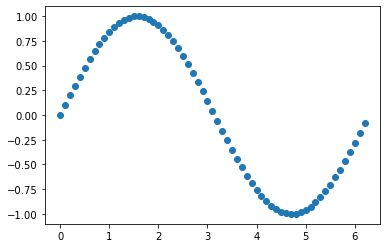

In [98]:
def get_data(num = 1):
    if num == 1:
        X = np.arange(0, 2*np.pi, 0.1).reshape(-1,1)
        y = np.sin(X).reshape(-1)
    elif num == 2:
        
        X = np.arange(0,50).reshape(-1,1)

        y1 = np.random.uniform(10,15,10)
        y2 = np.random.uniform(20,25,10)
        y3 = np.random.uniform(0,5,10)
        y4 = np.random.uniform(30,32,10)
        y5 = np.random.uniform(13,17,10)

        y = np.concatenate((y1,y2,y3,y4,y5))
    
    plt.scatter(X, y)
    
    return X, y

X, y = get_data(1)


## Model training

In [102]:
model = MyGbmRegressor(n_estimators=30, max_depth=2, learning_rate=1)
model.fit(X, y)

1:Loss: 0.06368, diff loss: -0.43499, residuals: Mean 0.00000, Std 0.25234
2:Loss: 0.03114, diff loss: -0.03254, residuals: Mean -0.00000, Std 0.17646
3:Loss: 0.02450, diff loss: -0.00664, residuals: Mean -0.00000, Std 0.15651
4:Loss: 0.01128, diff loss: -0.01321, residuals: Mean 0.00000, Std 0.10622
5:Loss: 0.00757, diff loss: -0.00371, residuals: Mean -0.00000, Std 0.08703
6:Loss: 0.00581, diff loss: -0.00177, residuals: Mean -0.00000, Std 0.07620
7:Loss: 0.00457, diff loss: -0.00124, residuals: Mean -0.00000, Std 0.06758
8:Loss: 0.00416, diff loss: -0.00041, residuals: Mean -0.00000, Std 0.06450
9:Loss: 0.00404, diff loss: -0.00012, residuals: Mean -0.00000, Std 0.06359
10:Loss: 0.00384, diff loss: -0.00020, residuals: Mean 0.00000, Std 0.06197
11:Loss: 0.00349, diff loss: -0.00035, residuals: Mean 0.00000, Std 0.05909
12:Loss: 0.00314, diff loss: -0.00035, residuals: Mean 0.00000, Std 0.05606
13:Loss: 0.00263, diff loss: -0.00051, residuals: Mean 0.00000, Std 0.05129
14:Loss: 0.002

## Interactive plot
You can choose step and see how to changing quality of prediction

In [103]:
model.plot_step_interactive()

interactive(children=(IntSlider(value=0, description='step', max=30, step=3), Output()), _dom_classes=('widget…

## Each step visualization

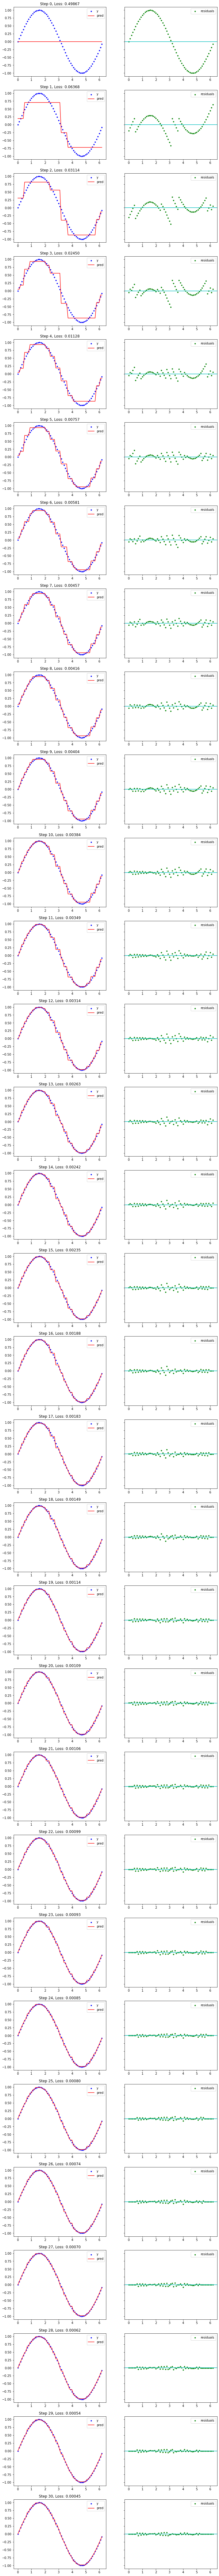

In [104]:
model.plot_steps()